# Demo AOFRAM&W sau khi sửa đổi trên dataset MovieLens 100k
## 1. Data processing

Dependencies

In [98]:
import numpy as np
import pandas as pd
import os
import statistics
from fractions import Fraction as F
from decimal import Decimal as D
import warnings
import csv
import time
import os
from numpy.random import choice
from sklearn.model_selection import train_test_split

df = pd.read_csv('data/ml/100k_cleanned.csv', usecols=['user_id', 'movie_id','avg_rating', 'k_ui'],
dtype={'user_id':'int32', 'movie_id':'int32','avg_rating':'float32', 'k_ui': 'float32'})

Train test split, sử dụng tỉ lệ **5:5**

In [99]:
train, test = train_test_split(df, test_size=0.5, random_state=42)
train.to_csv('data/ml/train_dataset.csv', index=False)
test.to_csv('data/ml/test_dataset.csv', index=False)

Tạo group, em làm giống báo cáo, tạo các group 2/3/4 thành viên, số lương 1000 mỗi loại

In [100]:
def Sharing_Group(df_ratings, n_group, n_userInGroup, fnameGroup):
    movie_id_mapping = {movie_id: idx for idx, movie_id in enumerate(df_ratings['movie_id'].unique())}
    df_ratings['movie_id_mapped'] = df_ratings['movie_id'].map(movie_id_mapping)

    group = choice(df_ratings['user_id'].unique(), size=(n_group, n_userInGroup))
    col_sl = np.zeros((n_group, 1))

    n = n_group
    i = 0

    while i < n:
        list_a = list(group[i, :])

        if len(set(list_a)) == len(list_a):
            temp1 = np.ones(len(movie_id_mapping))

            for a in range(n_userInGroup):
                user = list_a[a]

                user_movies = df_ratings[df_ratings['user_id'] == user]['movie_id_mapped'].values

                user_vector = np.zeros(len(movie_id_mapping))
                user_vector[user_movies] = 1

                temp1 = temp1 * user_vector

            col_sl[i] = int(np.sum(temp1))
            i += 1
        else:
            group = np.delete(group, i, axis=0)
            col_sl = np.delete(col_sl, i, axis=0)
            n -= 1
            if i != 0:
                i -= 1

    if int(np.size(group, 0)) != 0:
        data_temp = np.hstack((group, col_sl))
        column_names = [f'user_{y}' for y in range(n_userInGroup)] + ['n_common_rate']
        Groupn_pra = pd.DataFrame(data_temp, columns=column_names)
        Groupn_pra.to_csv(fnameGroup, index=False)

Tạo nhóm

In [101]:
for n_user_in_group in [2, 3, 4]:
    Sharing_Group(df, n_group=1000, n_userInGroup=n_user_in_group, fnameGroup=f'data/ml/groups/groups_{n_user_in_group}.csv')

Thông tin dataset

In [75]:
unique_users = df['user_id'].unique()
n_users = len(unique_users)
print(f"Số lượng user: {n_users}")

unique_movies = df['movie_id'].unique()
n_items = len(unique_movies)
print(f"Số lượng movie: {n_items}")


Số lượng user: 610
Số lượng movie: 9724


## Offline
Tạo hai ma trận factor (H và V), các ma trận bias (user, item)

In [102]:
class R:
  def __init__ (self, u, i, r ):
    self.user = u
    self.item = i
    self.rating = r

class Offline:
    def __init__ (self, fname_R , nfactor, anpha, lam, max_iter):
        self.fname_R = fname_R

        df_ratings = pd.read_csv(
            os.path.join(self.fname_R),
            usecols=['movie_id', 'user_id', 'avg_rating'],
            dtype={'movie_id': 'string', 'user_id': 'string', 'avg_rating': 'float32'})
        
        # df_copy = df_ratings.copy()

        # user_id_mapping = {user_id: i+1 for i, user_id in enumerate(df_copy['user_id'].unique())}
        # movie_id_mapping = {movie_id: i+1 for i, movie_id in enumerate(df_copy['movie_id'].unique())}

        df_features = df_ratings.pivot_table(
            index='user_id',
            columns='movie_id',
            values='avg_rating'
        ).fillna(0)

        self.R_matrix = df_features.to_numpy()
        self.n_users = int(np.size(self.R_matrix,0))      
        self.n_items = int(np.size(self.R_matrix,1))
        print(np.size(self.R_matrix,0))
        print(np.size(self.R_matrix,1))

        self.muy  = 0
        count = 0
        self.Y = []
        for u in range(self.n_users):
            for i in range(self.n_items):
                if self.R_matrix[u][i] != 0:
                    self.Y.append(R(u, i, self.R_matrix[u][i]))
                    self.muy = self.muy + self.R_matrix[u][i]
                    count += 1
        self.muy = self.muy / count
        print("Muy:",self.muy)
        self.nfactor = nfactor
        self.anpha = anpha
        self.max_iter = max_iter
        self.lam  = lam

        self.N_Ydata = int(np.size(self.Y))
        
        # temp = self.R_matrix
        # temp.tolist()     
        # self.muy = temp.mean()  # trung bình tất cả Rating trong hệ thống
        # print("Avg muy:",self.muy)

        # Khởi tạo giá trị ban đầu của Ou, Pi
        self.Ou = np.zeros(self.n_users)
        for i in range(self.n_users):
            self.Ou[i] = statistics.mean(self.R_matrix[i,:]) 
        
        self.Pi = np.zeros(self.n_items)
        for i in range(self.n_items):
            self.Pi[i] = statistics.mean(self.R_matrix[:,i])


    def SGD(self):
        print(str(self.n_users) +' : '+str(self.n_items))
        # khời tạo ma trận H V random
        self.H= np.random.uniform(-1, 1, size=(self.n_users, self.nfactor)) 
        self.V= np.random.uniform(-1, 1, size=(self.n_items, self.nfactor)) 
        #lặp với số lần là max_iter
        temp = self.max_iter
        while temp > 0:
            np.random.shuffle(self.Y)
            for i in range(self.N_Ydata):
                r = self.Y[i].rating
                Ou = self.Ou[self.Y[i].user]
                Pi = self.Pi[self.Y[i].item]
                h = self.H[self.Y[i].user,:]
                vT = self.V.transpose()[:,self.Y[i].item]
                v = self.V[self.Y[i].item,:]
                e = r - Ou -Pi - self.muy - h.dot(vT)   # độ lỗi

                H_plus = h - self.anpha*(self.lam*h - e*v)  
                V_plus = v - self.anpha*(self.lam*v - e*h)
                
                self.H[self.Y[i].user,:] = H_plus
                self.V[self.Y[i].item,:] = V_plus
                self.Ou[self.Y[i].user] = Ou +self.anpha*(e - self.lam*Ou)
                self.Pi[self.Y[i].item] = Pi +self.anpha*(e - self.lam*Pi)

            theta = 0
              # ngưỡng lỗi
            for b in range(self.N_Ydata): 
              th = self.H[self.Y[b].user,:]
              tv = self.V.transpose()[:,self.Y[b].item]
              theta =  pow((self.Y[b].rating - self.Ou[self.Y[b].user] - self.Pi[self.Y[b].item] - self.muy - th.dot(tv )), 2)
              if (theta <= pow(10,-6)):
                #print(temp)
                temp = 0
                break
              #print(temp)
              #print(theta, '-', self.Y[b].rating,'-', th.dot(tv))
            temp = temp - 1
            temp -=1
            #print(temp)
        
        # Lưu file
        # H: user factor
        H_pra = pd.DataFrame(self.H, columns = [x + str(y) for x in ['factor'] for y in  range(self.nfactor)] )
        fname = 'data/ml/factors/H.csv'
        H_pra.to_csv(fname, index = None)
        # V: item factor
        V_pra = pd.DataFrame(self.V, columns = [x + str(y) for x in ['factor'] for y in  range(self.nfactor)] )
        fname = 'data/ml/factors/V.csv'
        V_pra.to_csv(fname, index = None)
        Ou_pra = pd.DataFrame(self.Ou, columns =['Bias user'])
        fname = 'data/ml/factors/Ou.csv'
        Ou_pra.to_csv(fname, index = None)
        Pi_pra = pd.DataFrame(self.Pi, columns =['Bias item'])
        fname = 'data/ml/factors/Pi.csv'
        Pi_pra.to_csv(fname, index = None)

Chọn siêu tham số

In [77]:
nfactor = 60
anpha = 0.001
lam = 0.02
max_iter = 500

Train

In [103]:
step2 = Offline('data/ml/train_dataset.csv', nfactor, anpha, lam, max_iter)
step2.SGD()

610
7524
Muy: 3.5061486
610 : 7524


## Online

In [140]:
class AOFRAM_W:
    def __init__(self, G, Beta):
        self.lam = 0.02
        self.Beta = Beta
        self.G = G
        self.n_userGroup = int(np.size(self.G[0]))
        self.n_Group = int(np.size(self.G, 0))

        #! Đọc file H
        df_file_csv = pd.read_csv(os.path.join('data/ml/factors/H.csv'))
        self.H = df_file_csv.to_numpy()

        #! Đọc file V
        df_file_csv = pd.read_csv(os.path.join('data/ml/factors/V.csv'))
        self.Q = df_file_csv.to_numpy()

        #! Đọc file Ou
        df = pd.read_csv('data/ml/factors/Ou.csv')
        self.Ou = df['Bias user'].values

        #! Đọc file Pi
        df = pd.read_csv('data/ml/factors/Pi.csv')
        self.Pi = df['Bias item'].values

        #! Đọc file Rating và k_ui
        df_ratings = pd.read_csv(
            os.path.join("/home/vtcong21/KLTN/reports/7-12_21-12/demo/data/ml/train_dataset.csv"),
            usecols=['user_id', 'movie_id', 'k_ui', 'avg_rating'],
            dtype={'user_id': 'string', 'movie_id': 'string', 'avg_rating': 'float32', 'k_ui': 'float32'}
        )

        # Pivot Ratings Matrix
        df_features = df_ratings.pivot_table(
            index='user_id',
            columns='movie_id',
            values='avg_rating',
        ).fillna(0)
        self.R_matrix = df_features.to_numpy()
        self.n_users = int(np.size(self.R_matrix, 0)) 
        self.n_items = int(np.size(self.R_matrix, 1))
        # print(self.n_users,"-",self.n_items)
        arr = np.array(self.R_matrix)
        self.G_RLM = np.zeros((self.n_Group, self.n_items)) # rating at least one member
        self.G_RAM = np.zeros((self.n_Group, self.n_items)) # rating all member
        # Caculate the Avg of all observed rating
        self.Muy  = 0
        count = 0
        self.Y = []      # tạo list y chứa các rating != 0 mỗi index có dạng (u,i,value) 
        for u in range(self.n_users):
            for i in range(self.n_items):
                if self.R_matrix[u][i] != 0:
                    self.Muy = self.Muy + self.R_matrix[u][i]
                    count += 1
        self.Muy = self.Muy / count

        # Store k_ui as a matrix
        df_kui = df_ratings.pivot_table(
            index='user_id',
            columns='movie_id',
            values='k_ui',
        ).fillna(0)
        self.K_ui_matrix = df_kui.to_numpy()

    def normalize_Kui(self):
        print("Normalizing K_ui")
        # Normalize K_ui using Min-Max normalization
        k_ui_min = np.min(self.K_ui_matrix)
        k_ui_max = np.max(self.K_ui_matrix)

        if k_ui_max > k_ui_min:  # Avoid division by zero
            self.K_ui_matrix = (self.K_ui_matrix - k_ui_min) / (k_ui_max - k_ui_min)

    def Calculate_Kui_Beta(self):
        print("---> K_ui_Beta\n")
        # Chuẩn hóa K_ui_matrix vào khoảng [Beta, 1]
        k_ui_min = np.min(self.K_ui_matrix)
        k_ui_max = np.max(self.K_ui_matrix)
        
        if k_ui_max > k_ui_min:  # Tránh chia cho 0
            normalized_matrix = (self.K_ui_matrix - k_ui_min) / (k_ui_max - k_ui_min)
        else:
            normalized_matrix = np.zeros_like(self.K_ui_matrix)  # Nếu toàn bộ giá trị bằng nhau

        # Map vào khoảng [Beta, 1]
        kui_beta_matrix = self.Beta + (1.0 - self.Beta) * normalized_matrix

        # Ghi vào file CSV
        dffile = pd.DataFrame(
            kui_beta_matrix,
            columns=[f'movie_{i}' for i in range(self.n_items)]
        )
        fname = './data/ml/profile/' + f'PF_Kui_Beta_G{self.n_userGroup}.csv'
        dffile.to_csv(fname, index=None)

        print(f"K_ui_Beta matrix has been saved to {fname}")

    def Caculate_Cui_Beta(self):
        print("---> Calculating Cui_Beta")
        fname = './data/ml/profile/' + 'PF_Cui_Beta_G' + str(self.n_userGroup) + '.csv'
        
        if os.path.exists(fname):
            os.remove(fname)
        
        # Tạo DataFrame để lưu kết quả
        dffile = pd.DataFrame([], columns=[f'item_{i}' for i in range(self.n_items)])
        dffile.to_csv(fname, index=None)

        # Đọc Group matrix và chuyển sang số nguyên
        fname_group = './data/ml/groups/groups_' + str(self.n_userGroup) + '.csv'
        df_Group = pd.read_csv(fname_group)
        G_matrix = df_Group.to_numpy().astype(int)  # Chuyển toàn bộ giá trị sang int

        # Tạo ma trận Cui
        self.Cui_matrix = np.zeros((self.n_Group * self.n_userGroup, self.n_items))
        
        for g in range(self.n_Group):
            print(f"Processing group {g + 1}/{self.n_Group}")
            for u in range(self.n_userGroup):
                user_index = G_matrix[g][u] - 1
                
                # Kiểm tra user_index có hợp lệ không
                if not (0 <= user_index < self.n_users):
                    raise IndexError(f"Invalid user index: {user_index}. Check group file and user IDs.")
                
                print(f"  Processing user {u + 1}/{self.n_userGroup} in group {g + 1}")
                
                c_values = []

                for i in range(self.n_items):
                    if self.R_matrix[user_index][i] != 0:
                        c = abs(self.R_matrix[user_index][i] - self.Caculate_Predict_Rating(user_index, i))
                    else:
                        c = abs(
                            self.Ou[user_index] +
                            self.Pi[i] +
                            self.Muy -
                            np.dot(np.array(self.H[user_index]), np.array(self.Q[i]))
                        )
                    c_values.append(c)
                
                # Chuẩn hóa c_values
                c_min = min(c_values)
                c_max = max(c_values)
                if c_max > c_min:  # Tránh chia cho 0
                    normalized_values = [(c - c_min) / (c_max - c_min) for c in c_values]
                else:
                    normalized_values = [0] * self.n_items

                # Lưu vào ma trận Cui
                self.Cui_matrix[g * self.n_userGroup + u] = normalized_values

                # Lưu vào file CSV
                with open(fname, mode='a', newline='') as file:
                    writer = csv.writer(file)
                    writer.writerow(normalized_values)

        print(f"Cui_Beta matrix has been saved to {fname}")



    def Caculate_Predict_Rating(self, user, item):
        return self.Ou[user] + self.Pi[item] + self.Muy + np.dot(self.H[user], self.Q[item])

    def Caculate_Weights(self):
        print("Calculating Weights")
        self.Weight = []

        if os.path.exists('./data/ml/profile/F_Weight.csv'):
            os.remove('./data/ml/profile/PF_Weight.csv')

        dffile = pd.DataFrame([], columns=[x + str(y) for x in ['movie'] for y in range(self.n_items)])
        fname = './data/ml/profile/PF_Weight.csv'
        dffile.to_csv(fname, index=None)

        for g in range(self.n_Group):
            temp = []
            for u in range(self.n_userGroup):
                l = []
                for i in range(self.n_items):
                    w = self.K_ui_matrix[self.G[g][u] - 1][i] *  self.Cui_matrix[self.G[g][u] - 1][i]  # Use normalized k_ui directly
                    l.append(w)
                temp.append(l)
                self.Weight.append(l)

            with open('./data/ml/profile/PF_Weight.csv', mode='a', newline='') as file:
                writer = csv.writer(file)
                for row in temp:
                    writer.writerow(row)

    def RLM(self):    
        print('Tới RLM rồi nè!')
        print("Ma trận Weight có ", str(np.size(self.Weight, 0)), "dòng !")
        for a in range (self.n_Group):
            for b in range (self.n_items):
                tu = 0.0
                mau = 0.0
                for c in range (self.n_userGroup):
                    user = self.G[a,c]      #! lấy index thứ c tại group a 
                    rating = self.R_matrix[user-1, b]   #! lấy rating cúa user cá nhân
                    infl = self.Influ[user-1]
                    tu += rating*self.Weight[a*self.n_userGroup+c][b]
                    if rating != 0:
                        mau += infl
                if(mau !=0):
                    self.G_RLM[a,b] = tu/mau
                else:
                    self.G_RLM[a,b] = 0
    def RAM(self):
        Weight_fname = './data/ml/profile/PF_Weight.csv'
        df_Weight = pd.read_csv(Weight_fname)
        self.Weight = df_Weight.to_numpy()
        print('Tới RAM rồi nè!')
        for i in range (self.n_items):
            for g in range(self.n_Group):
                check = False
                for u in range (self.n_userGroup):
                    userid = self.G[g][u]
                    if(self.R_matrix[userid-1][i] != 0):
                        check = True
                
                if(check):
                    sum_avg = 0.0
                    sum_weight = 0.0
                    for c in range (self.n_userGroup):
                        userid = self.G[g,c]      #! lấy index thứ c tại group a
                        if(self.R_matrix[userid-1][i] == 0):
                            rating = self.Caculate_Predict_Rating(userid-1,i)
                        else:  
                            rating = self.R_matrix[userid-1, i]   #! lấy rating cúa user cá nhân

                        sum_avg += rating*self.Weight[g*self.n_userGroup+c][i]
                        sum_weight += self.Weight[g*self.n_userGroup+c][i]
                    if(sum_weight != 0):
                        self.G_RAM[g,i] = sum_avg/sum_weight
                    else:
                        self.G_RAM[g,i] = 0

    def Ridge_regression(self, type):
        print('Performing Ridge Regression')
        self.type = type
        self.col_factor = int(np.size(self.Q, 1))
        self.Og = np.zeros(self.n_Group)
        self.Hg = np.zeros((self.n_Group, self.col_factor))

        if self.type == 'RLM':
            self.GM = self.G_RLM
        elif self.type == 'RAM':
            self.GM = self.G_RAM

        for a in range(self.n_Group):
            temp = list(self.GM[a, :])
            available_item = self.n_items - int(temp.count(0))

            self._V = np.zeros((available_item, self.col_factor))
            self._pi = np.zeros((1, available_item))
            z = np.ones((1, available_item))
            self._g = []
            i = 0
            for b in range(self.n_items):
                rating = self.GM[a, b]
                if rating != 0:
                    self._g.append(rating)
                    self._V[i, :] = self.Q[b, :]
                    self._pi[0, i] = self.Pi[b]
                    i += 1

            I = np.eye(self.col_factor + 1)
            _V_col_end = np.ones((available_item, 1))
            self._V = np.hstack((self._V, _V_col_end))

            temp1 = (self._g - self._pi - self.Muy * z).dot(self._V)
            temp2 = np.linalg.pinv(self._V.transpose().dot(self._V) + self.lam * I)
            hg = temp1.dot(temp2)

            og = hg[0, self.col_factor]
            hg = np.delete(hg, np.s_[-1])
            self.Og[a] = og
            self.Hg[a, :] = hg

        #! Ridge Regression results: Group Factor Hg and bias group Og

    def Find_ListItem(self):
        print('Tới Find List rồi nè!')
        print('Tới list')
        self.L_item = []
        for a in range (self.n_Group): 
            temp = []
            for b in range (self.n_items): 
                tt = 0
                for c in range (self.n_userGroup):
                    user = self.G[a, c] 
                    if (self.R_matrix[user-1, b] == 0):     #! lấy các item chưa được user nào trong Group trải nghiệm
                        tt +=1
                if (tt == self.n_userGroup):
                    temp.append(b)
            self.L_item.append(temp)     #! mỗi item trong L là 1 list item khuyết

    def Find_ratingG(self):
        print('Tới Find RG rồi nè!')
        self.List_ItemG = []
        count = 0
        sum1 = 0
        for a in range(self.n_Group):
            temp = []
            for b in (self.L_item[a]): #! xét mỗi item trong list vừa tìm đc
                ratingG = self.Og[a] + self.Pi[b] + np.dot(np.array(self.Hg[a]),np.array(self.Q[b])) + self.Muy
                sum1 += ratingG
                count+=1
                if (ratingG >= 3):
                    temp.append(b)
            self.List_ItemG.append(temp)
        dffile =  pd.DataFrame(self.List_ItemG)
        fname = './data/ml/profile/PF_AVG_G'+ str(self.n_userGroup)+'.csv' #! => Mỗi dòng trong file là 1 Group và
                                                                    #! danh sách các item đề xuất cho Group đó
        dffile.to_csv(fname, index = None)
    def Profile_Aggregation(self):
        df_Weight = pd.read_csv('./data/ml/profile/PF_Weight.csv')
        Weight_Matrix = df_Weight.to_numpy()

        df_Group = pd.read_csv('./data/ml/groups/groups_4.csv')
        Group = df_Group.to_numpy()
        self.Profile_Aggregation = []
        for g in range(self.n_Group):
            l = np.zeros(self.n_items).tolist()
            sum_weight = np.zeros(self.n_items).tolist()
            for u in range(self.n_userGroup):
                for i in range(self.n_items):
                    if(self.R_matrix[G[g][u] - 1][i] != 0):
                        l[i] += self.R_matrix[G[g][u] - 1][i] * Weight_Matrix[g*self.n_userGroup+u][i]
                    else:
                        l[i] += self.Caculate_Predict_Rating(G[g][u] - 1, i) * Weight_Matrix[g*self.n_userGroup+u][i]
                    sum_weight[i] += Weight_Matrix[g*self.n_userGroup+u][i]

            for idx in range(self.n_items):
                l[idx] = l[idx] / sum_weight[idx]
            for idx in range(self.n_items):
                l[idx] = 5*(l[idx] - min(l))/(max(l)-min(l))
            
            self.Profile_Aggregation.append(l)

        dffile = pd.DataFrame(self.Profile_Aggregation, columns = [x + str(y) for x in ['Item'] for y in  range(self.n_items)])
        fname = './data/ml/profile/PF_Profile_Aggregation.csv'
        dffile.to_csv(fname, index = None)

        df = pd.read_csv('./data/ml/profile/PF_Profile_Aggregation.csv')
        line_count = len(df)
        row_count = len(df.columns)
        print(f'Số dòng trong tệp CSV: {line_count}')
        print(f'Số cột trong tệp CSV: {row_count}')



Giả sử group với n = 4

In [152]:
nUserGroup = 2
file_group = './data/ml/groups/groups_' + str(nUserGroup) + '.csv'

if nUserGroup == 2:
    df_group = pd.read_csv(
        os.path.join(file_group),
        usecols=['user_0', 'user_1'],
        dtype={'user_0': 'int32', 'user_1': 'int32'}
    )
elif nUserGroup == 3:
    df_group = pd.read_csv(
        os.path.join(file_group),
        usecols=['user_0', 'user_1', 'user_2'],
        dtype={'user_0': 'int32', 'user_1': 'int32', 'user_2': 'int32'}
    )
elif nUserGroup == 4:
    df_group = pd.read_csv(
        os.path.join(file_group),
        usecols=['user_0', 'user_1', 'user_2', 'user_3'],
        dtype={'user_0': 'int32', 'user_1': 'int32', 'user_2': 'int32', 'user_3': 'int32'}
    )
elif nUserGroup == 5:
    df_group = pd.read_csv(
        os.path.join(file_group),
        usecols=['user_0', 'user_1', 'user_2', 'user_3', 'user_4'],
        dtype={'user_0': 'int32', 'user_1': 'int32', 'user_2': 'int32', 'user_3': 'int32', 'user_4': 'int32'}
    )


In [153]:
G = df_group.to_numpy()
step = AOFRAM_W(G, 0.4)
step.normalize_Kui()
step.Calculate_Kui_Beta()
step.Caculate_Cui_Beta()
step.Caculate_Weights()
step.RAM()
step.Ridge_regression('RAM')
step.Find_ListItem()
step.Find_ratingG()

Normalizing K_ui
---> K_ui_Beta

K_ui_Beta matrix has been saved to ./data/ml/profile/PF_Kui_Beta_G2.csv
---> Calculating Cui_Beta
Processing group 1/998
  Processing user 1/2 in group 1
  Processing user 2/2 in group 1
Processing group 2/998
  Processing user 1/2 in group 2
  Processing user 2/2 in group 2
Processing group 3/998
  Processing user 1/2 in group 3
  Processing user 2/2 in group 3
Processing group 4/998
  Processing user 1/2 in group 4
  Processing user 2/2 in group 4
Processing group 5/998
  Processing user 1/2 in group 5
  Processing user 2/2 in group 5
Processing group 6/998
  Processing user 1/2 in group 6
  Processing user 2/2 in group 6
Processing group 7/998
  Processing user 1/2 in group 7
  Processing user 2/2 in group 7
Processing group 8/998
  Processing user 1/2 in group 8
  Processing user 2/2 in group 8
Processing group 9/998
  Processing user 1/2 in group 9
  Processing user 2/2 in group 9
Processing group 10/998
  Processing user 1/2 in group 10
  Processi

## Đánh giágiá

In [148]:
class Measure:
    def __init__(self, Testing, G, IRG, fname):
        self.test = Testing         # test matrix
        self.n_items = int(np.size(self.test,1))
        self.n_users = int(np.size(self.test,0))
        self.IRG = IRG
        self.n_Group = len(self.IRG)
        self.G = G
        self.n_userGroup = int(np.size(self.G,1))
        self.fscore = np.zeros((self.n_Group, 6)) 
        self.fname = fname

        if(self.n_userGroup % 2 == 0):
            self.Standard = int(self.n_userGroup / 2)
        else:
            self.Standard = int(self.n_userGroup / 2) + 1
        
        print(self.Standard)

        print(self.n_users," users and ", self.n_items," item\n")
    def Fscore(self):
            print('Vô   F-score r nè!')
            self.T = []
            self.C = []
            # g là groupid
            for g in range(self.n_Group):
                tempT = []
                tempC = []
                if (len(self.IRG[g])==0): #nếu group đó ko có item nào đk đề xuất
                    self.T.append(tempT)
                    continue
                # b là mỗi item được recommend cho group
                
                for d in self.IRG[g]:   #! mỗi index IRG là 1 list các item đề xuất cho Group đó
                    # c là số phần tử (user) trong 1 group
                    #  temp2 là biến điều kiện
                    
                    b= int(float(d))    #! index của item
                    score = 0
                    count = 0
                    for c in range(self.n_userGroup):
                        userid =  self.G[g,c]
                        if(userid >= self.n_users or b >= self.n_items or self.test[userid-1,b] == 0):
                            count += 1
                        elif (self.test[userid-1,b] >= 3):
                            score += 1
                    #! item phải đc tất ít nhất nửa thành viên đánh giá > 3 mới đc tính
                    if(self.n_userGroup % 2 == 0):
                        if (count <= self.Standard):
                            tempC.append(b)
                        if (count <= self.Standard and score >= self.Standard):
                            tempT.append(b)
                    elif (self.n_userGroup == 3):
                        if (count <= 1):
                            tempC.append(b)
                        if (count <= 1 and score >=2):
                            tempT.append(b)
                    else:
                        if (count < self.Standard):
                            tempC.append(b)
                        if (count < self.Standard and score >= self.Standard):
                            tempT.append(b)
                self.T.append(tempT)
                self.C.append(tempC)
                #! C là danh sách item dự đoán của hệ thống (kết quả của giai đoạn gợi ý)
                #! T là danh sách tư vấn chính xác trên thực tế

            print('Xong T!')
            for g in range (self.n_Group):
                if (len(self.T[g]) > 1):
                    precisionG = len(set(self.T[g]) & set(self.C[g])) / len(self.C[g])
                    recallG = len(set(self.T[g]) & set(self.C[g])) / len(self.T[g])
                    if (precisionG ==0 and recallG ==0):
                        fscoreG = 0
                    else: 
                        fscoreG = 2*precisionG*recallG/(precisionG + recallG)
                        self.fscore[g,0] = precisionG
                        self.fscore[g,1] = recallG
                        self.fscore[g,2] = fscoreG
                        self.fscore[g,3] = len(self.T[g])
                        self.fscore[g,4] = len(self.C[g])
                self.fscore[g,5] = len(self.IRG[g])

            print("Length:",len(self.IRG[0]))
            print("Length:",len(self.IRG[1]))
            print('Xong fscore sắp lưu')
            t1 = pd.DataFrame(self.G, columns = [x + str(y) for x in ['user_'] for y in  range(self.n_userGroup)])
            
            t3 = pd.DataFrame(self.fscore, columns = ['precisionG', 'recallG', 'fscoreG','T','C','Quantity'])
            t4 = pd.concat([t1,t3], axis = 1)
            t4.to_csv(self.fname)


# read test file
df_testing = pd.read_csv(
    os.path.join("./data/ml/test_dataset.csv"),
    usecols=['user_id', 'movie_id', 'avg_rating', 'k_ui'],
    dtype={'user_id': 'int32', 'movie_id': 'int32', 'avg_rating': 'float32', 'k_ui': 'float32'})
# init matrix fill 0
df_testing_features = df_testing.pivot_table(
    index='user_id',
    columns='movie_id',
    values='avg_rating'
).fillna(0)

testing = df_testing_features.to_numpy()

# Đọc file Group 
nUserGroup = 4
file_group = './data/ml/groups/groups_' + str(nUserGroup) + '.csv'
if(nUserGroup == 2):
    df_group = pd.read_csv(
        os.path.join(file_group),
        usecols=['user_0','user_1'],
        dtype={'user_0': 'int32' ,'user_1': 'int32'})
elif nUserGroup == 3:
    df_group = pd.read_csv(
        os.path.join(file_group),
        usecols=['user_0','user_1','user_2'],
        dtype={'user_0': 'int32' ,'user_1': 'int32','user_2':'int32'})
elif nUserGroup == 4:
    df_group = pd.read_csv(
        os.path.join(file_group),
        usecols=['user_0','user_1','user_2','user_3'],
        dtype={'user_0': 'int32' ,'user_1': 'int32','user_2':'int32','user_3':'int32'})
elif nUserGroup == 5:
    df_group = pd.read_csv(
        os.path.join(file_group),
        usecols=['user_0','user_1','user_2','user_3','user_4'],
        dtype={'user_0': 'int32' ,'user_1': 'int32','user_2':'int32','user_3':'int32','user_4':'int32'})

G2 = df_group.to_numpy() 
# Đọc danh sách gợi ý cho G
ffname = './data/ml/profile/PF_AVG_G'+str(nUserGroup) + '.csv'
lIG =[]
with open(ffname) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        bbb=[]
        if line_count == 0:
            line_count = 1
            continue
        else:
            bbb =  [x for x in row[:] if x != '']
        lIG.append(list(bbb)) 


nUserGroup = np.size(G2[0])
fname = './data/ml/measure/fscore_G' + str(nUserGroup)+  '.csv'
step4 = Measure(testing, G2, lIG, fname)
step4.Fscore()



2
610  users and  7529  item

Vô   F-score r nè!
Xong T!
Length: 6949
Length: 4951
Xong fscore sắp lưu


Visualize

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 989 entries, 0 to 988
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  989 non-null    int64  
 1   user_0      989 non-null    int64  
 2   user_1      989 non-null    int64  
 3   user_2      989 non-null    int64  
 4   user_3      989 non-null    int64  
 5   precisionG  989 non-null    float64
 6   recallG     989 non-null    float64
 7   fscoreG     989 non-null    float64
 8   T           989 non-null    float64
 9   C           989 non-null    float64
 10  Quantity    989 non-null    float64
dtypes: float64(6), int64(5)
memory usage: 85.1 KB
None
   Unnamed: 0  user_0  user_1  user_2  user_3  precisionG  recallG  fscoreG  \
0           0     460     113     170     250         0.0      0.0      0.0   
1           1     401     609     147     240         1.0      1.0      1.0   
2           2     193     201     237     362         1.0      1.0   

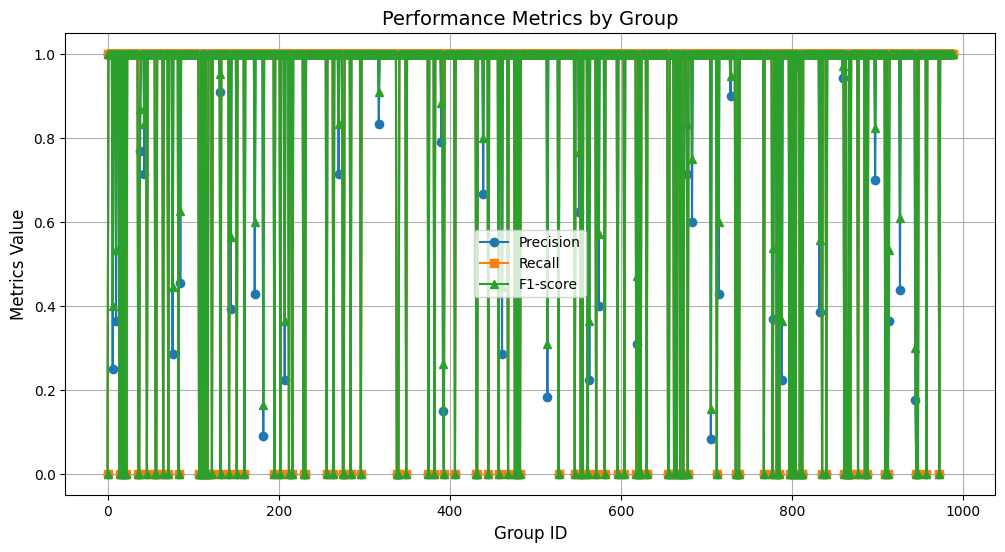

In [151]:
import pandas as pd
import matplotlib.pyplot as plt

fname = './data/ml/measure/fscore_G4.csv' 
try:
    data = pd.read_csv(fname)
    
    print(data.info())
    print(data.head())
    avg_fscore = data['fscoreG'].mean()
    print(f"Trung bình F1-score: {avg_fscore}")

    groups = data.index
    plt.figure(figsize=(12, 6))
    
    plt.plot(groups, data['precisionG'], label='Precision', marker='o')
    plt.plot(groups, data['recallG'], label='Recall', marker='s')
    plt.plot(groups, data['fscoreG'], label='F1-score', marker='^')

    plt.title('Performance Metrics by Group', fontsize=14)
    plt.xlabel('Group ID', fontsize=12)
    plt.ylabel('Metrics Value', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()

except Exception as e:
    print(f"Error reading or visualizing the file: {e}")
